In [1]:
import subprocess

def get_total_frames(video_path):
    # Construct the ffprobe command
    command = [
        'ffprobe', 
        '-v', 'error', 
        '-select_streams', 'v:0',  # Select the first video stream
        '-show_entries', 'stream=nb_frames', 
        '-of', 'default=noprint_wrappers=1:nokey=1', 
        video_path
    ]
    # Execute the command and capture the output
    result = subprocess.run(command, check=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    
    # Return the result (frame count) after stripping whitespace
    return int(result.stdout.strip())



In [2]:
video_file = '/root/capsule/data/behavior_716325_2024-05-31_10-31-14/behavior-videos/bottom_camera.avi'
total_frames_original = get_total_frames(video_file)

total_frames_original

2689718

In [5]:
video_file = '/root/capsule/data/matt_test_DLC_LP_results_20240920/video_predictonly2/bottom_camera.mp4'
total_frames_processed = get_total_frames(video_file)

total_frames_processed

2689719

In [37]:

df = pd.read_csv('/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/outputs/predictions_pixel_error.csv')
keypoint_names = list(df.columns[1:-1])
print(f"\nkeypoint_names: {keypoint_names}, {len(keypoint_names)}")
temp_list = []
# compute mean pixel error per bodypart
for col in df.columns[1:-1]:
    mean  = float(format(np.nanmean(df[col].astype("float"), axis=0), '.3f'))
    stdev = float(format(np.nanstd(df[col].astype("float"), axis=0), '.3f'))
    temp_list.append("{:.2f} ± {:.2f}".format(mean, stdev))

# compute mean pixel error averaged over all keypoints
df = df.iloc[: , 1:-1]
mean  = float(format(np.nanmean(df.astype("float")), '.3f'))
stdev = float(format(np.nanstd(df.astype("float")), '.3f'))
temp_list.append("{:.2f} ± {:.2f}".format(mean, stdev))
print("Average error: {:.2f} ± {:.2f} pixel".format(mean, stdev))
print(temp_list)
mean_pix = pd.DataFrame({'mean_pix_error': temp_list})
keypoint_names.append('Average')
mean_pix.index = keypoint_names
mean_pix


keypoint_names: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l'], 11
Average error: 2.09 ± 6.24 pixel
['1.78 ± 1.21', '2.42 ± 3.96', '2.32 ± 2.11', '1.86 ± 1.52', '2.16 ± 2.01', '3.48 ± 20.65', '4.95 ± 11.94', '1.65 ± 4.66', '4.25 ± 3.79', '2.42 ± 1.50', '1.04 ± 0.67', '2.09 ± 6.24']


,mean_pix_error
nose_tip,1.78 ± 1.21
jaw,2.42 ± 3.96
tongue_tip_right,2.32 ± 2.11
tongue_tip_center,1.86 ± 1.52
tongue_tip_left,2.16 ± 2.01
pointer_finger_r,3.48 ± 20.65
paw_wrist_r,4.95 ± 11.94
pointer_finger_l,1.65 ± 4.66
paw_wrist_l,4.25 ± 3.79
spout_r,2.42 ± 1.50


In [5]:
import numpy as np
import pandas as pd

# Assumptions for the proof-of-concept model
total_savings = 500000  # Total savings available
purchase_price = 1200000  # Home purchase price
mortgage_rate_annual = 0.07  # Annual mortgage interest rate
mortgage_term_years = 30
loan_balance_initial = 350000  # Student loan balance
loan_rate_annual = 0.07  # Annual student loan interest rate
loan_term_years = 10
appreciation_rate_annual = 0.01  # Property appreciation rate
horizon_years = 5  # Time horizon for net worth calculation

# Helper function to compute remaining balance after n payments
def remaining_balance(principal, annual_rate, term_years, n_payments):
    if principal <= 0 or n_payments == 0:
        return max(principal, 0)
    r = annual_rate / 12
    N = term_years * 12
    # Monthly payment formula
    payment = principal * r * (1 + r)**N / ((1 + r)**N - 1)
    # Remaining balance after n payments
    return principal * (1 + r)**n_payments - payment * (((1 + r)**n_payments - 1) / r)

allocations = np.arange(0, 1.1, 0.1)
results = []

for alloc in allocations:
    down_payment = total_savings * alloc
    extra_loan_payment = total_savings * (1 - alloc)
    
    # Adjust initial principals
    mortgage_principal = max(purchase_price - down_payment, 0)
    student_loan_principal = max(loan_balance_initial - extra_loan_payment, 0)
    
    # Compute remaining balances after the horizon
    mortgage_remaining = remaining_balance(mortgage_principal, mortgage_rate_annual, mortgage_term_years, horizon_years * 12)
    loan_remaining = remaining_balance(student_loan_principal, loan_rate_annual, loan_term_years, horizon_years * 12)
    
    # Home value at horizon
    home_value = purchase_price * (1 + appreciation_rate_annual) ** horizon_years
    home_equity = home_value - mortgage_remaining
    
    # Compute net worth = home_equity - remaining loan
    net_worth = home_equity - loan_remaining
    
    results.append({
        "Allocation (%)": alloc * 100,
        "Down Payment ($)": down_payment,
        "Extra Loan Payment ($)": extra_loan_payment,
        "Home Equity ($)": round(home_equity, 2),
        "Remaining Loan Balance ($)": round(loan_remaining, 2),
        "Net Worth ($)": round(net_worth, 2)
    })

df = pd.DataFrame(results)
df

,Allocation (%),Down Payment ($),Extra Loan Payment ($),Home Equity ($),Remaining Loan Balance ($),Net Worth ($)
0,0.0,0.0,500000.0,131632.98,0.00,131632.98
1,10.0,50000.0,450000.0,178698.78,0.00,178698.78
2,20.0,100000.0,400000.0,225764.57,0.00,225764.57
3,30.0,150000.0,350000.0,272830.37,0.00,272830.37
4,40.0,200000.0,300000.0,319896.16,29318.55,290577.61
5,50.0,250000.0,250000.0,366961.96,58637.10,308324.86
6,60.0,300000.0,200000.0,414027.75,87955.64,326072.11
7,70.0,350000.0,150000.0,461093.55,117274.19,343819.35
8,80.0,400000.0,100000.0,508159.34,146592.74,361566.60
9,90.0,450000.0,50000.0,555225.14,175911.29,379313.85


In [10]:
import numpy as np
import pandas as pd

total_savings = 500000  # Total savings available
purchase_price = 1200000  # Home purchase price
mortgage_rate_annual = 0.07  # Annual mortgage interest rate
mortgage_term_years = 30
loan_balance_initial = 350000  # Student loan balance
loan_rate_annual = 0.07  # Annual student loan interest rate
loan_term_years = 10
appreciation_rate_annual = 0.01  # Property appreciation rate
horizon_years = 5  # Time horizon for net worth calculation

# Helper function to compute remaining balance after n payments
def remaining_balance(principal, annual_rate, term_years, n_payments):
    if principal <= 0 or n_payments == 0:
        return max(principal, 0)
    r = annual_rate / 12
    N = term_years * 12
    payment = principal * r * (1 + r)**N / ((1 + r)**N - 1)
    return principal * (1 + r)**n_payments - payment * (((1 + r)**n_payments - 1) / r)

# Monthly rates and total payments
r_l = loan_rate_annual / 12
N_l = loan_term_years * 12
r_m = mortgage_rate_annual / 12
N_m = mortgage_term_years * 12

allocations = np.arange(0, 1.1, 0.1)
years = np.arange(1, horizon_years + 1)

rows = []
for alloc in allocations:
    down_payment = total_savings * alloc
    extra_loan_payment = total_savings * (1 - alloc)
    
    # Adjust initial principals
    mortgage_principal = max(purchase_price - down_payment, 0)
    student_loan_principal = max(loan_balance_initial - extra_loan_payment, 0)
    
    # Compute fixed monthly payments
    mortgage_payment = (mortgage_principal * r_m * (1 + r_m)**N_m / ((1 + r_m)**N_m - 1)
                        if mortgage_principal > 0 else 0.0)
    loan_payment = (student_loan_principal * r_l * (1 + r_l)**N_l / ((1 + r_l)**N_l - 1)
                    if student_loan_principal > 0 else 0.0)

    for y in years:
        # Balances and equity at year y
        mortgage_remaining = remaining_balance(mortgage_principal, mortgage_rate_annual, mortgage_term_years, y * 12)
        loan_remaining = remaining_balance(student_loan_principal, loan_rate_annual, loan_term_years, y * 12)
        home_value = purchase_price * (1 + appreciation_rate_annual)**y
        home_equity = home_value - mortgage_remaining
        net_worth = home_equity - loan_remaining
        
        # Annual outflows
        lump_extra = extra_loan_payment if y == 1 else 0.0
        annual_loan_outflow = lump_extra + loan_payment * 12
        annual_mortgage_outflow = mortgage_payment * 12
        
        total_debt_outflow = annual_loan_outflow + annual_mortgage_outflow
        avg_monthly_debt_expense = total_debt_outflow / 12
        
        rows.append({
            "Allocation (%)": alloc * 100,
            "Year": y,
            "Net Worth ($)": round(net_worth, 2),
            "Avg Monthly Debt Expense ($)": round(avg_monthly_debt_expense, 2)
        })

df_yearly_debt = pd.DataFrame(rows)
df_yearly_debt[df_yearly_debt['Year']==2]

,Allocation (%),Year,Net Worth ($),Avg Monthly Debt Expense ($)
1,0.0,2,49380.63,7983.63
6,10.0,2,98328.11,7650.98
11,20.0,2,147275.58,7318.33
16,30.0,2,196223.05,6985.68
21,40.0,2,202589.15,7233.57
26,50.0,2,208955.25,7481.46
31,60.0,2,215321.35,7729.35
36,70.0,2,221687.45,7977.24
41,80.0,2,228053.55,8225.13
46,90.0,2,234419.66,8473.02


In [22]:
import numpy as np
import pandas as pd

# Assumptions for the extended model
total_savings = 500000  # Total savings available
purchase_price = 1200000  # Home purchase price
mortgage_rate_annual = 0.07  # Annual mortgage interest rate
mortgage_term_years = 30
loan_balance_initial = 350000  # Student loan balance
loan_rate_annual = 0.07  # Annual student loan interest rate
loan_term_years = 10
appreciation_rate_annual = 0.01  # Property appreciation rate
horizon_years = 5  # Time horizon for net worth calculation

annual_income = 260000  # Annual gross income
annual_living_expenses = 165000  # Annual non-debt living expenses
savings_rate_annual = 0.04  # Interest/growth rate on saved cash

# Helper function to compute remaining balance after n payments
def remaining_balance(principal, annual_rate, term_years, n_payments):
    if principal <= 0 or n_payments == 0:
        return max(principal, 0)
    r = annual_rate / 12
    N = term_years * 12
    payment = principal * r * (1 + r)**N / ((1 + r)**N - 1)
    return principal * (1 + r)**n_payments - payment * (((1 + r)**n_payments - 1) / r)

# Monthly rates and total payments
r_l = loan_rate_annual / 12
N_l = loan_term_years * 12
r_m = mortgage_rate_annual / 12
N_m = mortgage_term_years * 12

allocations = np.arange(0, 1.1, 0.1)
years = np.arange(1, horizon_years + 1)

rows = []
for alloc in allocations:
    down_payment = total_savings * alloc
    extra_loan_payment = total_savings * (1 - alloc)
    
    # Adjust initial principals
    mortgage_principal = max(purchase_price - down_payment, 0)
    student_loan_principal = max(loan_balance_initial - extra_loan_payment, 0)
    
    # Compute fixed monthly payments
    mortgage_payment = (mortgage_principal * r_m * (1 + r_m)**N_m / ((1 + r_m)**N_m - 1)
                        if mortgage_principal > 0 else 0.0)
    loan_payment = (student_loan_principal * r_l * (1 + r_l)**N_l / ((1 + r_l)**N_l - 1)
                    if student_loan_principal > 0 else 0.0)
    
    cash_savings = 0.0  # initialize cash/savings balance
    
    for y in years:
        # Balances and equity at year y
        mortgage_remaining = remaining_balance(mortgage_principal, mortgage_rate_annual, mortgage_term_years, y * 12)
        loan_remaining = remaining_balance(student_loan_principal, loan_rate_annual, loan_term_years, y * 12)
        home_value = purchase_price * (1 + appreciation_rate_annual)**y
        home_equity = home_value - mortgage_remaining
        
        # Annual outflows
        lump_extra = extra_loan_payment if y == 1 else 0.0
        annual_loan_outflow = lump_extra + loan_payment * 12
        annual_mortgage_outflow = mortgage_payment * 12
        total_debt_outflow = annual_loan_outflow + annual_mortgage_outflow
        
        # Update cash/savings balance
        surplus = annual_income - annual_living_expenses - total_debt_outflow
        cash_savings = cash_savings * (1 + savings_rate_annual) + surplus
        
        # Calculate net worth including cash
        net_worth = home_equity + cash_savings - loan_remaining
        
        # Average monthly debt expense
        avg_monthly_debt_expense = total_debt_outflow / 12
        
        rows.append({
            "Allocation": alloc * 100,
            "Year": y,
            "Net Worth": round(net_worth, 2),
            "Cash/Savings": round(cash_savings, 2),
            "Avg Monthly Debt Expense": round(avg_monthly_debt_expense, 2)
        })

df_yearly = pd.DataFrame(rows)
df_yearly

,Allocation,Year,Net Worth,Cash/Savings,Avg Monthly Debt Expense
0,0.0,1,-476613.84,-500803.56,49650.30
1,0.0,2,-472258.63,-521639.26,7983.63
2,0.0,3,-467670.75,-543308.39,7983.63
3,0.0,4,-462814.02,-565844.29,7983.63
4,0.0,5,-457648.63,-589281.62,7983.63
5,10.0,1,-373129.93,-446811.74,45150.98
6,10.0,2,-363167.85,-461495.96,7650.98
7,10.0,3,-352766.42,-476767.54,7650.98
8,10.0,4,-341882.44,-492649.99,7650.98
9,10.0,5,-330468.95,-509167.73,7650.98


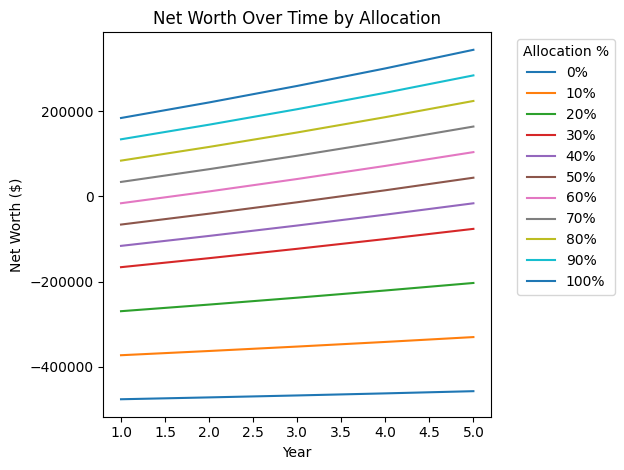

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
df = df_yearly

# Chart 1: Net Worth over Time for each Allocation
plt.figure()
for alloc in df["Allocation"].unique():
    subset = df[df["Allocation"] == alloc]
    plt.plot(subset["Year"], subset["Net Worth"], label=f"{int(alloc)}%")
plt.xlabel("Year")
plt.ylabel("Net Worth ($)")
plt.title("Net Worth Over Time by Allocation")
plt.legend(title="Allocation %", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


In [24]:
import numpy as np
import pandas as pd

# Assumptions for the extended model
total_savings = 500000  # Total savings available
purchase_price = 1200000  # Home purchase price
mortgage_rate_annual = 0.07  # Annual mortgage interest rate
mortgage_term_years = 30
loan_balance_initial = 350000  # Student loan balance
loan_rate_annual = 0.07  # Annual student loan interest rate
loan_term_years = 10
appreciation_rate_annual = 0.01  # Property appreciation rate
horizon_years = 5  # Time horizon for net worth calculation

annual_income = 260000  # Annual gross income
annual_living_expenses = 165000  # Annual non-debt living expenses
savings_rate_annual = 0.04  # Interest/growth rate on saved cash

# Helper function to compute remaining balance after n payments
def remaining_balance(principal, annual_rate, term_years, n_payments):
    if principal <= 0 or n_payments == 0:
        return max(principal, 0)
    r = annual_rate / 12
    N = term_years * 12
    payment = principal * r * (1 + r)**N / ((1 + r)**N - 1)
    return principal * (1 + r)**n_payments - payment * (((1 + r)**n_payments - 1) / r)

# Monthly rates and total payments
r_l = loan_rate_annual / 12
N_l = loan_term_years * 12
r_m = mortgage_rate_annual / 12
N_m = mortgage_term_years * 12

allocations = np.arange(0, 1.1, 0.1)
years = np.arange(1, horizon_years + 1)

rows = []
for alloc in allocations:
    down_payment = total_savings * alloc
    desired_extra_loan = total_savings * (1 - alloc)
    
    # Cap the extra loan payment at the loan balance, rollover remainder to savings
    actual_extra_loan = min(desired_extra_loan, loan_balance_initial)
    leftover_initial = max(desired_extra_loan - loan_balance_initial, 0)
    
    # Adjust initial principals
    mortgage_principal = max(purchase_price - down_payment, 0)
    student_loan_principal = loan_balance_initial - actual_extra_loan
    
    # Compute fixed monthly payments
    mortgage_payment = (mortgage_principal * r_m * (1 + r_m)**N_m / ((1 + r_m)**N_m - 1)
                        if mortgage_principal > 0 else 0.0)
    loan_payment = (student_loan_principal * r_l * (1 + r_l)**N_l / ((1 + r_l)**N_l - 1)
                    if student_loan_principal > 0 else 0.0)
    
    # Initialize cash/savings with leftover from over-payment
    cash_savings = leftover_initial
    
    for y in years:
        mortgage_remaining = remaining_balance(mortgage_principal, mortgage_rate_annual, mortgage_term_years, y * 12)
        loan_remaining = remaining_balance(student_loan_principal, loan_rate_annual, loan_term_years, y * 12)
        home_value = purchase_price * (1 + appreciation_rate_annual)**y
        home_equity = home_value - mortgage_remaining
        
        lump_extra = actual_extra_loan if y == 1 else 0.0
        annual_loan_outflow = lump_extra + loan_payment * 12
        annual_mortgage_outflow = mortgage_payment * 12
        total_debt_outflow = annual_loan_outflow + annual_mortgage_outflow
        
        # Update cash/savings balance from income minus expenses
        surplus = annual_income - annual_living_expenses - total_debt_outflow
        cash_savings = cash_savings * (1 + savings_rate_annual) + surplus
        
        net_worth = home_equity + cash_savings - loan_remaining
        avg_monthly_debt_expense = total_debt_outflow / 12
        
        rows.append({
            "Allocation (%)": alloc * 100,
            "Year": y,
            "Cash/Savings ($)": round(cash_savings, 2),
            "Net Worth ($)": round(net_worth, 2),
            "Avg Monthly Debt Expense ($)": round(avg_monthly_debt_expense, 2)
        })

df_yearly = pd.DataFrame(rows)
df_yearly

,Allocation (%),Year,Cash/Savings ($),Net Worth ($),Avg Monthly Debt Expense ($)
0,0.0,1,-194803.56,-170613.84,37150.30
1,0.0,2,-203399.26,-154018.63,7983.63
2,0.0,3,-212338.79,-136701.15,7983.63
3,0.0,4,-221635.90,-118605.63,7983.63
4,0.0,5,-231304.90,-99671.92,7983.63
5,10.0,1,-242811.74,-169129.93,36817.65
6,10.0,2,-249335.96,-151007.85,7650.98
7,10.0,3,-256121.14,-132120.02,7650.98
8,10.0,4,-263177.73,-112410.19,7650.98
9,10.0,5,-270516.58,-91817.81,7650.98


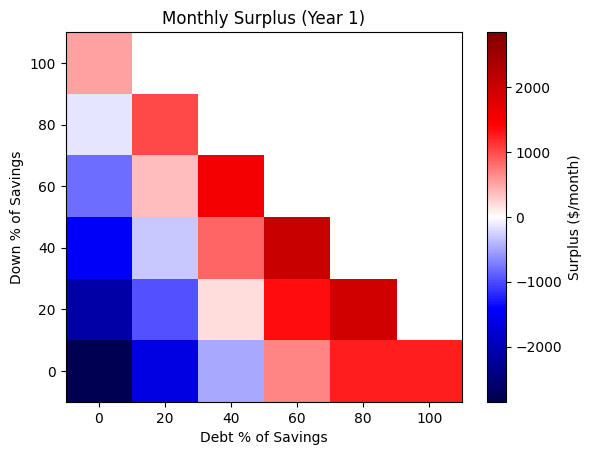

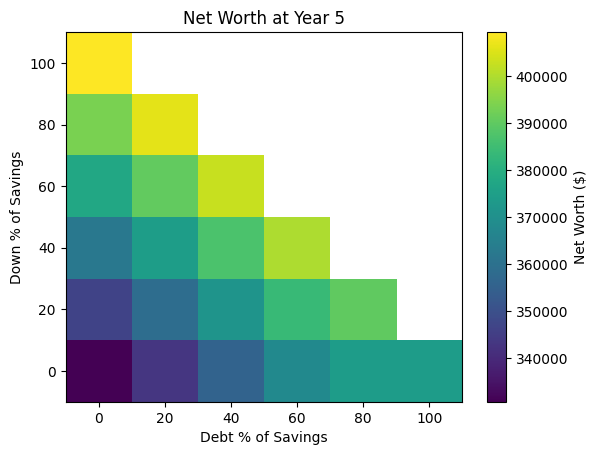

In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma

# Assumptions
total_savings = 500000
purchase_price = 1000000
mortgage_rate = 0.07
mortgage_term = 30
loan_balance = 350000
loan_rate = 0.07
loan_term = 10
appreciation = 0.01
years = 5
income = 260000
living = 165000
save_rate = 0.04

def rem_bal(P, r, term, n):
    if P <= 0: return 0.0
    m = r/12
    N = term*12
    pay = P*m*(1+m)**N/((1+m)**N-1)
    return P*(1+m)**n - pay*(( (1+m)**n - 1)/m)

# Build scenarios
steps = np.arange(0,1.01,0.2)
records = []
for d in steps:
    for t in steps:
        if d + t <= 1:
            s = 1 - d - t
            dp = total_savings*d
            lp = total_savings*t
            init_cash = total_savings*s + max(lp - loan_balance,0)
            xtra_loan = min(lp, loan_balance)
            mP = max(purchase_price - dp, 0)
            lP = max(loan_balance - xtra_loan, 0)
            # payments
            m_pay = mP*(mortgage_rate/12)*(1+mortgage_rate/12)**(mortgage_term*12)/(((1+mortgage_rate/12)**(mortgage_term*12)-1)) if mP>0 else 0
            l_pay = lP*(loan_rate/12)*(1+loan_rate/12)**(loan_term*12)/(((1+loan_rate/12)**(loan_term*12)-1)) if lP>0 else 0
            # monthly surplus
            m_surplus = income/12 - living/12 - (m_pay + l_pay)
            # net worth over time
            cash = init_cash
            nw_list = []
            for yr in range(1, years+1):
                cash = cash*(1+save_rate) + (income - living - (m_pay*12 + l_pay*12))
                eq = purchase_price*(1+appreciation)**yr - rem_bal(mP, mortgage_rate, mortgage_term, yr*12)
                l_rem = rem_bal(lP, loan_rate, loan_term, yr*12)
                nw_list.append(eq + cash - l_rem)
            records.append({'Down %':d*100,'Debt %':t*100,'Save %':s*100,
                            'Monthly Surplus':m_surplus,
                            **{f'NW Yr{yr}':nw for yr,nw in enumerate(nw_list,1)}})

df = pd.DataFrame(records)

# Prepare heatmaps
downs = sorted(df['Down %'].unique())
debts = sorted(df['Debt %'].unique())

debts = [f"{d:.0f}" for d in debts]  # no decimals
downs = [f"{d:.0f}" for d in downs]

aff = df.pivot(index='Down %', columns='Debt %', values='Monthly Surplus')
nw5 = df.pivot(index='Down %', columns='Debt %', values='NW Yr5')

# Mask NaNs for safe plotting
aff_masked = ma.masked_invalid(aff.values)
nw5_masked = ma.masked_invalid(nw5.values)

# Get color scale limits centered around 0 with buffer
max_val = np.nanmax(np.abs(aff_masked))
buffer = 50
vmax = max_val + buffer
vmin = -vmax

# Monthly Surplus Heatmap
plt.figure()
plt.imshow(
    aff_masked, 
    origin='lower',
    aspect='auto',
    cmap='seismic',
    vmin=vmin,
    vmax=vmax
)
plt.xticks(ticks=np.arange(len(debts)), labels=debts)
plt.yticks(ticks=np.arange(len(downs)), labels=downs)
plt.xlabel('Debt % of Savings')
plt.ylabel('Down % of Savings')
plt.title('Monthly Surplus (Year 1)')
plt.colorbar(label='Surplus ($/month)')
plt.show()

# Net Worth Heatmap
plt.figure()
plt.imshow(
    nw5_masked,
    origin='lower',
    aspect='auto',
    cmap='viridis'
)
plt.xticks(ticks=np.arange(len(debts)), labels=debts)
plt.yticks(ticks=np.arange(len(downs)), labels=downs)
plt.xlabel('Debt % of Savings')
plt.ylabel('Down % of Savings')
plt.title('Net Worth at Year 5')
plt.colorbar(label='Net Worth ($)')
plt.show()


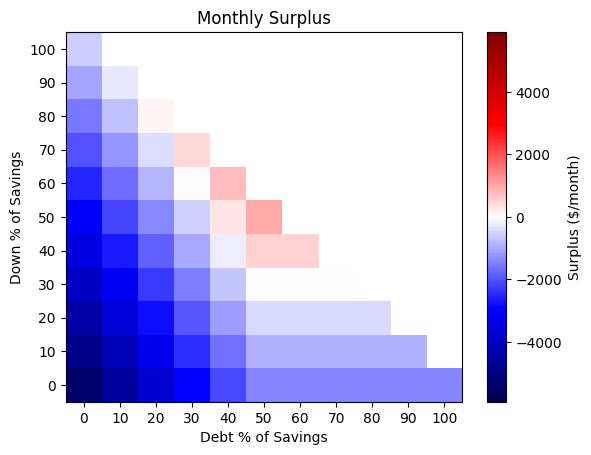

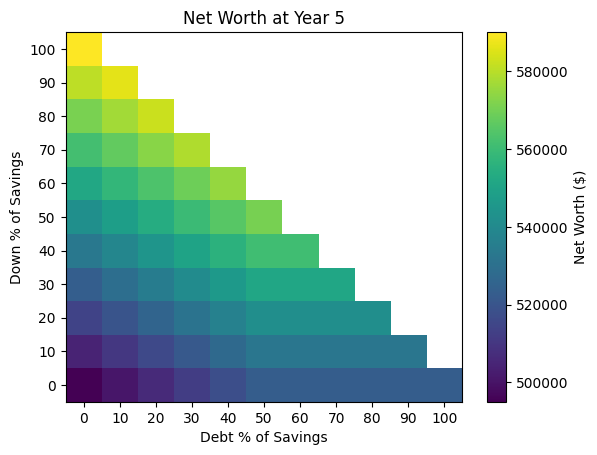

    Down %  Monthly Mortgage Payment
0        0                   9314.23
1       10                   8835.22
2       20                   8356.20
3       30                   7877.18
4       40                   7398.16
5       50                   6919.15
6       60                   6440.13
7       70                   5961.11
8       80                   5482.09
9       90                   5003.07
10     100                   4524.06
    Debt %  Monthly Loan Payment
0        0               3974.18
1       10               3156.63
2       20               2339.09
3       30               1521.54
4       40                704.00
5       50                  0.00
6       60                  0.00
7       70                  0.00
8       80                  0.00
9       90                  0.00
10     100                  0.00


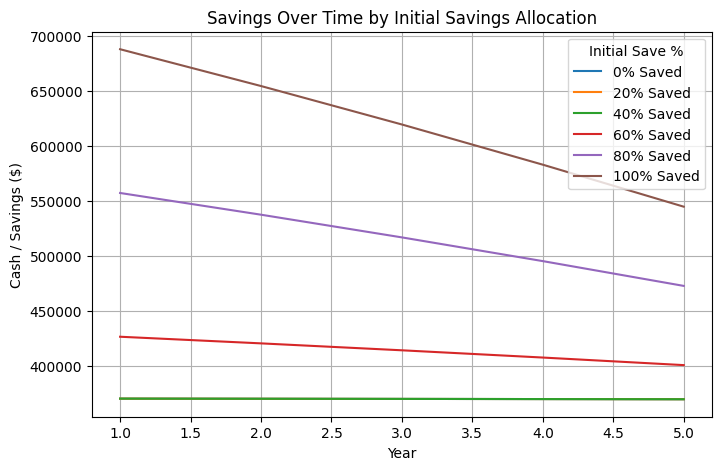

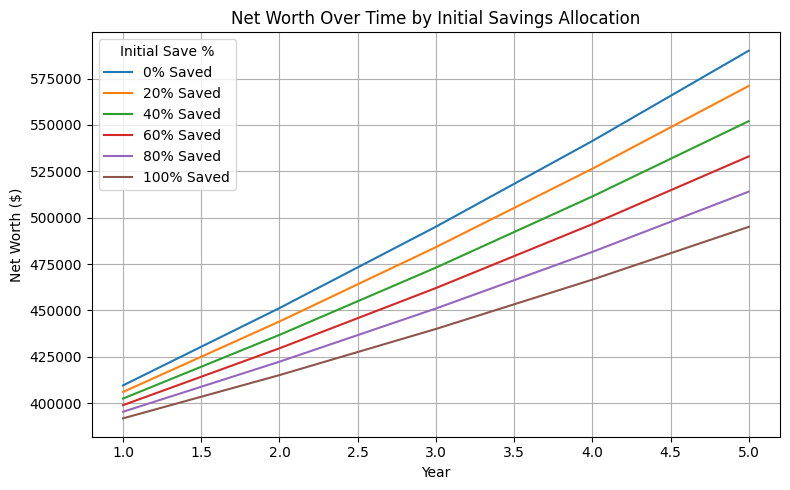

In [50]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.ma as ma

def build_scenario_df(
    total_savings=720_000,
    purchase_price=1_400_000,
    mortgage_rate=0.07,
    mortgage_term=30,
    loan_balance=350_000,
    loan_rate=0.065,
    loan_term=10,
    appreciation=0.01,
    years=5,
    income=260_000,
    living=165_000,
    save_rate=0.045,
    step=0.1
):
    def rem_bal(P, r, term, n):
        if P <= 0: return 0.0
        m = r / 12
        N = term * 12
        pay = P * m * (1 + m) ** N / ((1 + m) ** N - 1)
        return P * (1 + m) ** n - pay * (((1 + m) ** n - 1) / m)

    steps = np.arange(0, 1 + 1e-9, step)
    records = []

    for d in steps:
        for t in steps:
            if d + t <= 1:
                s = 1 - d - t
                dp = total_savings * d
                lp = total_savings * t

                # initial cash and loan paydown
                init_cash = total_savings * s + max(lp - loan_balance, 0)
                xtra_loan = min(lp, loan_balance)
                mP = max(purchase_price - dp, 0)
                lP = max(loan_balance - xtra_loan, 0)

                # calculate payments
                m_pay = (mP * (mortgage_rate / 12) * (1 + mortgage_rate / 12) ** (mortgage_term * 12)
                         / (((1 + mortgage_rate / 12) ** (mortgage_term * 12) - 1))) if mP > 0 else 0
                l_pay = (lP * (loan_rate / 12) * (1 + loan_rate / 12) ** (loan_term * 12)
                         / (((1 + loan_rate / 12) ** (loan_term * 12) - 1))) if lP > 0 else 0
                
                # DTI as % of gross monthly income
                dti = (m_pay + l_pay) / (income / 12) * 100
                
                #monthly surplus to measure cashflow
                m_surplus = income / 12 - living / 12 - (m_pay + l_pay)

                cash = init_cash
                nw_list = []
                cash_list = []

                # simulate over years
                for yr in range(1, years + 1):
                    cash = cash * (1 + save_rate) + (
                        income - living - (m_pay * 12 + l_pay * 12)
                    )
                    cash_list.append(cash)
                    eq = purchase_price * (1 + appreciation) ** yr - rem_bal(
                        mP, mortgage_rate, mortgage_term, yr * 12
                    )
                    l_rem = rem_bal(lP, loan_rate, loan_term, yr * 12)
                    nw_list.append(eq + cash - l_rem)

                record = {
                    'Down %': round(d*100),
                    'Debt %': round(t*100),
                    'Save %': round(s*100),
                    'Monthly Surplus': m_surplus,
                    'DTI %': round(dti, 2), 
                }
                # add NW and Save year columns
                record.update({f'NW Yr{yr}': nw for yr, nw in enumerate(nw_list, 1)})
                record.update({f'Save Yr{yr}': sv for yr, sv in enumerate(cash_list, 1)})
                records.append(record)

    # Summarize by Down % (mortgage) and Debt % (loan)
    mortgage_summary = pd.DataFrame([
        {'Down %': round(d*100),
        'Monthly Mortgage Payment': round(
            (max(purchase_price - total_savings * d, 0) *
            (mortgage_rate / 12) * (1 + mortgage_rate / 12) ** (mortgage_term * 12) /
            ((1 + mortgage_rate / 12) ** (mortgage_term * 12) - 1)
            ) if (purchase_price - total_savings * d) > 0 else 0, 2)}
        for d in np.arange(0, 1 + 1e-9, step)
    ])

    loan_summary = pd.DataFrame([
        {'Debt %': round(t*100),
        'Monthly Loan Payment': round(
            (max(loan_balance - min(total_savings * t, loan_balance), 0) *
            (loan_rate / 12) * (1 + loan_rate / 12) ** (loan_term * 12) /
            ((1 + loan_rate / 12) ** (loan_term * 12) - 1)
            ) if (loan_balance - min(total_savings * t, loan_balance)) > 0 else 0, 2)}
        for t in np.arange(0, 1 + 1e-9, step)
    ])

    return pd.DataFrame(records),mortgage_summary, loan_summary

def prepare_heatmaps(df):
    # pivot tables
    aff = df.pivot(index='Down %', columns='Debt %', values='Monthly Surplus')
    nw5 = df.pivot(index='Down %', columns='Debt %', values='NW Yr5')

    # mask NaNs
    aff_masked = ma.masked_invalid(aff.values)
    nw5_masked = ma.masked_invalid(nw5.values)

    # axis labels
    downs = list(map(int, aff.index.values))
    debts = list(map(int, aff.columns.values))

    # color scale for surplus centered at zero
    max_val = np.nanmax(np.abs(aff_masked))
    buffer = max_val * 0.1  # 10% buffer
    vmax = max_val + buffer
    vmin = -vmax

    return downs, debts, aff_masked, nw5_masked, vmin, vmax

def plot_heatmaps(downs, debts, aff_masked, nw5_masked, vmin, vmax):
    # Surplus Heatmap
    plt.figure()
    plt.imshow(aff_masked, origin='lower', aspect='auto',
               cmap='seismic', vmin=vmin, vmax=vmax)
    plt.xticks(ticks=np.arange(len(debts)), labels=debts)
    plt.yticks(ticks=np.arange(len(downs)), labels=downs)
    plt.xlabel('Debt % of Savings')
    plt.ylabel('Down % of Savings')
    plt.title('Monthly Surplus')
    plt.colorbar(label='Surplus ($/month)')
    plt.show()

    # Net Worth Heatmap
    plt.figure()
    plt.imshow(nw5_masked, origin='lower', aspect='auto', cmap='viridis')
    plt.xticks(ticks=np.arange(len(debts)), labels=debts)
    plt.yticks(ticks=np.arange(len(downs)), labels=downs)
    plt.xlabel('Debt % of Savings')
    plt.ylabel('Down % of Savings')
    plt.title('Net Worth at Year 5')
    plt.colorbar(label='Net Worth ($)')
    plt.show()


def plot_savings_over_time(df, years=5, save_percents=[0,20,40,60,80,100]):
    plt.figure(figsize=(8,5))
    for pct in save_percents:
        subset = df[np.isclose(df['Save %'], pct, atol=1e-6)]
        if not subset.empty:
            # pick scenario with highest NW at year 'years'
            # best = subset.loc[subset[f'NW Yr{years}'].idxmax()]
            best = subset.loc[subset[f'Save Yr{years}'].idxmax()]
            savings = [best[f'Save Yr{yr}'] for yr in range(1, years+1)]
            plt.plot(range(1, years+1), savings, label=f'{int(pct)}% Saved')
    plt.xlabel('Year')
    plt.ylabel('Cash / Savings ($)')
    plt.title('Savings Over Time by Initial Savings Allocation')
    plt.legend(title='Initial Save %')
    plt.grid(True)


def plot_networth_over_time(df, years=5, save_percents=[0,20,40,60,80,100]):
    plt.figure(figsize=(8,5))
    for pct in save_percents:
        subset = df[np.isclose(df['Save %'], pct, atol=1e-6)]
        if not subset.empty:
            # pick scenario with highest NW at year 'years'
            best = subset.loc[subset[f'NW Yr{years}'].idxmax()]
            networth = [best[f'NW Yr{yr}'] for yr in range(1, years+1)]
            plt.plot(range(1, years+1), networth, label=f'{int(pct)}% Saved')
    plt.xlabel('Year')
    plt.ylabel('Net Worth ($)')
    plt.title('Net Worth Over Time by Initial Savings Allocation')
    plt.legend(title='Initial Save %')
    plt.grid(True)


# Run model and plotting
df, mortgage_summary, loan_summary = build_scenario_df()


downs, debts, aff_masked, nw5_masked, vmin, vmax = prepare_heatmaps(df)
plot_heatmaps(downs, debts, aff_masked, nw5_masked, vmin, vmax)

print(mortgage_summary)
print(loan_summary)

plot_savings_over_time(df)
plot_networth_over_time(df)
plt.tight_layout()
plt.show()

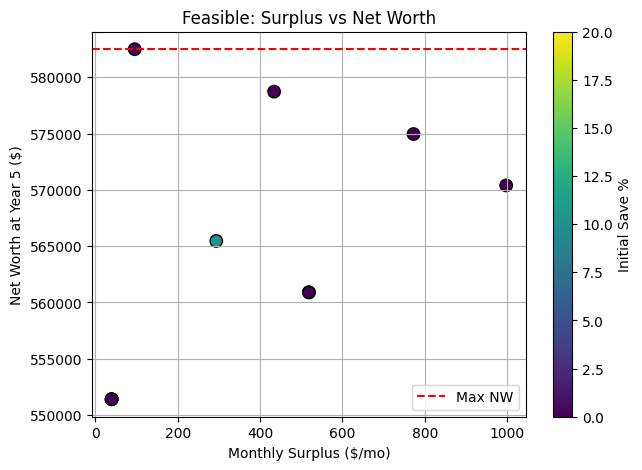

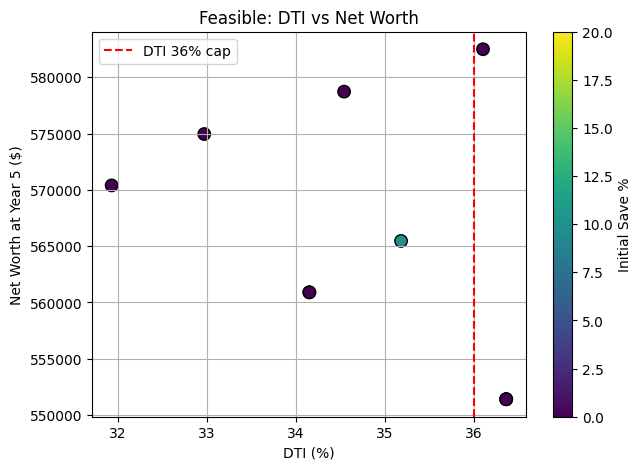

In [51]:
import matplotlib.pyplot as plt

def analyze_feasible_scenarios(df, surplus_cutoff=500, year=5, dti_limit=36):
    """
    1) Filters scenarios with monthly surplus >= surplus_cutoff.
    2) Sorts by net worth at the specified year.
    3) Plots:
       • Surplus vs Net Worth (colored by Save %)
       • DTI % vs Net Worth   (colored by Save %, with 36% cap line)
    """
    # 1) filter out cash‑flow–negative scenarios
    feasible = df[df['Monthly Surplus'] >= surplus_cutoff].copy()

    # 2) sort by target net worth
    col_nw = f'NW Yr{year}'
    feasible = feasible.sort_values(by=col_nw, ascending=False)

    # — Plot A: Surplus vs Net Worth —
    plt.figure(figsize=(7,5))
    sc1 = plt.scatter(
        feasible['Monthly Surplus'], 
        feasible[col_nw], 
        c=feasible['Save %'], 
        cmap='viridis', 
        edgecolor='k', 
        s=80
    )
    plt.colorbar(sc1, label='Initial Save %')
    plt.axhline(y=feasible[col_nw].max(), color='red',
                linestyle='--', label='Max NW')
    plt.xlabel('Monthly Surplus ($/mo)')
    plt.ylabel(f'Net Worth at Year {year} ($)')
    plt.title('Feasible: Surplus vs Net Worth')
    plt.legend()
    plt.grid(True)
    plt.show()

    # — Plot B: DTI vs Net Worth —
    plt.figure(figsize=(7,5))
    sc2 = plt.scatter(
        feasible['DTI %'],
        feasible[col_nw],
        c=feasible['Save %'],
        cmap='viridis',
        edgecolor='k',
        s=80
    )
    plt.colorbar(sc2, label='Initial Save %')
    plt.axvline(x=dti_limit, color='red',
                linestyle='--', label=f'DTI {dti_limit}% cap')
    plt.xlabel('DTI (%)')
    plt.ylabel(f'Net Worth at Year {year} ($)')
    plt.title('Feasible: DTI vs Net Worth')
    plt.legend()
    plt.grid(True)
    plt.show()

    return feasible


feasible = analyze_feasible_scenarios(df, surplus_cutoff=0, year=5, dti_limit=36)


In [52]:
feasible

,Down %,Debt %,Save %,Monthly Surplus,DTI %,NW Yr1,NW Yr2,NW Yr3,NW Yr4,NW Yr5,Save Yr1,Save Yr2,Save Yr3,Save Yr4,Save Yr5
62,80,20,0,95.485776,36.10,408640.468944,449090.494762,491465.375847,535888.234223,582490.553237,1145.829308,2343.220935,3594.495185,4902.076776,6268.499539
59,70,30,0,434.013415,34.54,408147.997295,447987.202439,489621.252390,533160.666336,578723.313667,5208.160981,10650.689207,16338.131203,22281.508088,28492.336933
55,60,40,0,772.541055,32.97,407655.525646,446883.910115,487777.128933,530433.098449,574956.074097,9270.492655,18958.157479,29081.767220,39660.939400,50716.174328
50,50,50,0,997.520717,31.93,406984.670826,445431.955777,485423.614001,527046.541447,570393.110439,22420.248602,35399.408390,48962.630370,63136.197338,77947.574820
49,50,40,10,293.523258,35.18,405878.695165,443270.251284,482265.386854,522960.808933,565459.621092,78762.279096,85828.860752,93213.438583,100930.322415,108994.466020
43,40,50,10,518.502920,34.15,405207.840345,441818.296946,479911.871922,519574.251931,560896.657433,91912.035043,102270.111664,113094.301732,124405.580353,136225.866512
44,40,60,0,518.502920,34.15,405207.840345,441818.296946,479911.871922,519574.251931,560896.657433,91912.035043,102270.111664,113094.301732,124405.580353,136225.866512
35,30,50,20,39.485124,36.36,403431.009864,438204.638115,474400.129844,512101.962415,551400.204428,161403.821485,169140.814937,177225.973094,185674.963368,194504.158204
36,30,60,10,39.485124,36.36,403431.009864,438204.638115,474400.129844,512101.962415,551400.204428,161403.821485,169140.814937,177225.973094,185674.963368,194504.158204
37,30,70,0,39.485124,36.36,403431.009864,438204.638115,474400.129844,512101.962415,551400.204428,161403.821485,169140.814937,177225.973094,185674.963368,194504.158204


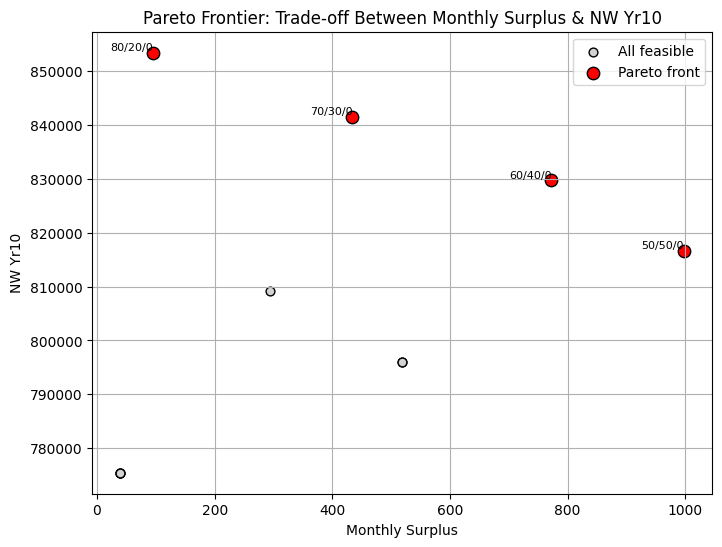

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def compute_pareto_front(df, x='Monthly Surplus', y='NW Yr5'):
    """
    Return the subset of df that is not dominated on both x ↑ and y ↑.
    A row r is dominated if there exists another row s with
      s[x] ≥ r[x] AND s[y] ≥ r[y], with at least one strict.
    """
    pareto_mask = []
    vals = df[[x, y]].to_numpy()
    for i, (vx, vy) in enumerate(vals):
        # is there any row that strictly dominates this one?
        dominates = np.any(
            (vals[:,0] >= vx) & (vals[:,1] >= vy) &
            ((vals[:,0] >  vx) | (vals[:,1] > vy))
        )
        pareto_mask.append(not dominates)
    return df[pareto_mask]

# 1) Build your full scenarios table:
df, mortgage_summary, loan_summary = build_scenario_df(
    total_savings=720_000,
    purchase_price=1_400_000,
    mortgage_rate=0.07,
    mortgage_term=30,
    loan_balance=350_000,
    loan_rate=0.065,
    loan_term=10,
    appreciation=0.01,
    years=10,
    income=260_000,
    living=165_000,
    save_rate=0.045,
    step=0.1
)

# 2) (Optional) filter to “feasible” by surplus or DTI etc.
feasible = df[df['Monthly Surplus'] >= 0].copy()

# 3) Compute Pareto front
var1 = 'Monthly Surplus'
var2 = 'NW Yr10'
pareto = compute_pareto_front(feasible, x=var1, y=var2)

# 4) Plot everything, highlighting the Pareto‐optimal points
plt.figure(figsize=(8,6))
plt.scatter(feasible[var1], feasible[var2],
            c='lightgray', edgecolor='k', s=40, label='All feasible')
plt.scatter(pareto[var1], pareto[var2],
            c='red', edgecolor='k', s=80, label='Pareto front')

for _, row in pareto.iterrows():
    plt.text(row[var1], row[var2],
             f"{int(row['Down %'])}/{int(row['Debt %'])}/{int(row['Save %'])}",
             fontsize=8, va='bottom', ha='right')

plt.xlabel(f'{var1}')
plt.ylabel(f'{var2}')
plt.title(f'Pareto Frontier: Trade‐off Between {var1} & {var2}')
plt.legend()
plt.grid(True)
plt.show()


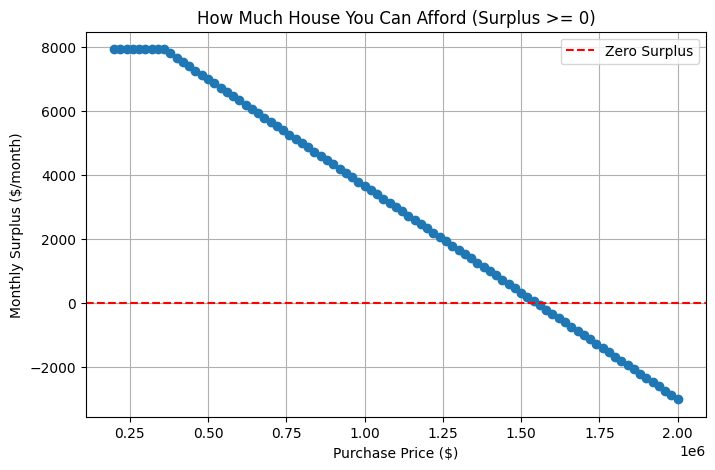

,Purchase Price,Mortgage Payment,Loan Payment,Monthly Surplus,DTI %
53,1260000,5987.722457,0,1928.944210,27.635642
54,1280000,6120.782956,0,1795.883711,28.249767
55,1300000,6253.843455,0,1662.823212,28.863893
56,1320000,6386.903954,0,1529.762713,29.478018
57,1340000,6519.964453,0,1396.702214,30.092144
58,1360000,6653.024952,0,1263.641715,30.706269
59,1380000,6786.085451,0,1130.581216,31.320394
60,1400000,6919.145950,0,997.520717,31.934520
61,1420000,7052.206449,0,864.460218,32.548645
62,1440000,7185.266948,0,731.399719,33.162771


In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (as per your scenario)
total_savings = 720_000
loan_balance = 350_000
loan_rate = 0.065
loan_term = 10
mortgage_rate = 0.07
mortgage_term = 30
income = 260_000
living = 165_000

# Fixed allocation: 50% down payment, 50% loan payoff
d_pct = 0.5
t_pct = 0.5

# Range of purchase prices to test
purchase_prices = np.arange(200_000, 2_000_001, 20_000)

results = []
for P in purchase_prices:
    dp = total_savings * d_pct
    lp = total_savings * t_pct
    
    # Mortgage principal
    mP = max(P - dp, 0)
    # Loan principal remaining after extra payoff
    xtra_loan = min(lp, loan_balance)
    lP = max(loan_balance - xtra_loan, 0)
    
    # Monthly mortgage payment
    m_pay = (mP * (mortgage_rate / 12) * (1 + mortgage_rate / 12) ** (mortgage_term * 12) /
             ((1 + mortgage_rate / 12) ** (mortgage_term * 12) - 1)) if mP > 0 else 0
    
    # Monthly loan payment
    l_pay = (lP * (loan_rate / 12) * (1 + loan_rate / 12) ** (loan_term * 12) /
             ((1 + loan_rate / 12) ** (loan_term * 12) - 1)) if lP > 0 else 0
    
    # Monthly surplus
    surplus = income / 12 - living / 12 - (m_pay + l_pay)
    # DTI %
    dti = (m_pay + l_pay) / (income / 12) * 100
    
    results.append({
        'Purchase Price': P,
        'Mortgage Payment': m_pay,
        'Loan Payment': l_pay,
        'Monthly Surplus': surplus,
        'DTI %': dti
    })

df_afford = pd.DataFrame(results)

# Plot Purchase Price vs Monthly Surplus
plt.figure(figsize=(8, 5))
plt.plot(df_afford['Purchase Price'], df_afford['Monthly Surplus'], marker='o')
plt.axhline(0, color='red', linestyle='--', label='Zero Surplus')
plt.xlabel('Purchase Price ($)')
plt.ylabel('Monthly Surplus ($/month)')
plt.title('How Much House You Can Afford (Surplus >= 0)')
plt.grid(True)
plt.legend()
plt.show()

df_afford[(df_afford['Purchase Price'] >= 1250000) & (df_afford['Purchase Price'] <= 1750000)]


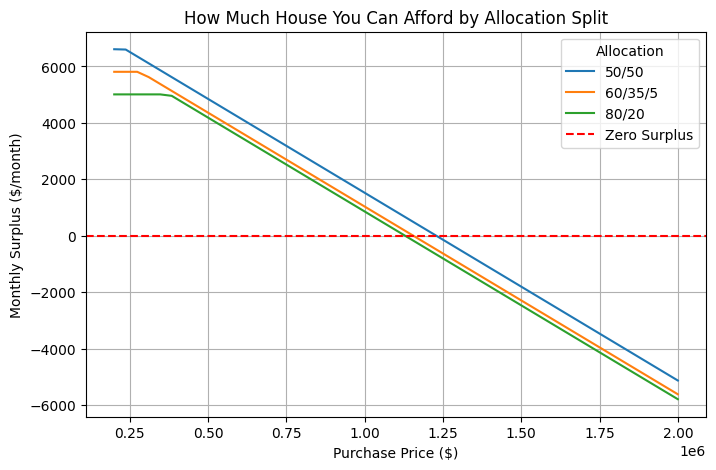

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters (as per your scenario)
total_savings = 470_000
loan_balance = 350_000
loan_rate = 0.065
loan_term = 10
mortgage_rate = 0.07
mortgage_term = 30
income = 260_000
living = 165_000

# Allocation splits to compare
splits = [
    {'label': '50/50',      'd_pct': 0.5,  't_pct': 0.5},
    {'label': '80/20',      'd_pct': 0.8,  't_pct': 0.2},
    {'label': '60/35/5',    'd_pct': 0.6,  't_pct': 0.35}
]

# Range of purchase prices to test
purchase_prices = np.linspace(200_000, 2_000_000, 50)

# Collect results
all_results = []

for split in splits:
    results = []
    for P in purchase_prices:
        dp = total_savings * split['d_pct']
        lp = total_savings * split['t_pct']
        
        # Mortgage principal
        mP = max(P - dp, 0)
        # Loan principal after extra payoff
        xtra_loan = min(lp, loan_balance)
        lP = max(loan_balance - xtra_loan, 0)
        
        # Monthly payments
        m_pay = (mP * (mortgage_rate / 12) * (1 + mortgage_rate / 12) ** (mortgage_term * 12) /
                 ((1 + mortgage_rate / 12) ** (mortgage_term * 12) - 1)) if mP > 0 else 0
        l_pay = (lP * (loan_rate / 12) * (1 + loan_rate / 12) ** (loan_term * 12) /
                 ((1 + loan_rate / 12) ** (loan_term * 12) - 1)) if lP > 0 else 0
        
        surplus = income / 12 - living / 12 - (m_pay + l_pay)
        
        results.append({
            'Purchase Price': P,
            'Monthly Surplus': surplus
        })
    df_split = pd.DataFrame(results)
    df_split['Allocation'] = split['label']
    all_results.append(df_split)

# Combine into one DataFrame
df_compare = pd.concat(all_results, ignore_index=True)

# Display the combined DataFrame

# Plot Purchase Price vs Monthly Surplus for each allocation
plt.figure(figsize=(8, 5))
for label, group in df_compare.groupby('Allocation'):
    plt.plot(group['Purchase Price'], group['Monthly Surplus'], label=label)
plt.axhline(0, color='red', linestyle='--', label='Zero Surplus')
plt.xlabel('Purchase Price ($)')
plt.ylabel('Monthly Surplus ($/month)')
plt.title('How Much House You Can Afford by Allocation Split')
plt.legend(title='Allocation')
plt.grid(True)
plt.show()
